### Hamiltonian Study - Evolution and Simulation
This notebook is intended to illustrate how to compute the energy expectation value for a quantum state that is produced using Hamiltonian consisting of multiple weighted Pauli strings.

The first section defines functions for creating a circuit with appended gates for the Hamiltonian term, executing those circuits, and computing the expectation value over all terms of the Hamiltonian.
The second section defines several simple functions for creating PauliEvolution circuits from the Hamiltonian Pault strings.
This is followed by a number of tests that evolve a Hamiltonian either classically or using a quantum evolution circuit and obtaining energy measures.
(There are several cells toward the end that are retained for bits of code that may be useful.)

### ------------------------------------------------------------------

In [1]:
import numpy as np
import copy
from math import sin, cos, pi

from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.primitives import Estimator

from qiskit.quantum_info import Operator, Pauli
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import PauliEvolutionGate

import scipy as sc
import matplotlib.pyplot as plt


backend = Aer.get_backend('qasm_simulator')
#backend = Aer.get_backend('statevector_simulator')
noise_model = None

# Set numpy print options to format floating point numbers
np.set_printoptions(precision=3, suppress=True)

verbose = False

# Observable Helper Functions
import observables as obs

obs.verbose = False


### ------------------------------------------------------------------

### Perform Simple Time Evolution of a Quantum State
This function operates on an initial state for the specified time under the action of a given Hamiltonian.
This is an extremely simplifed version.

In [2]:
# Simulate time evolution (this is a simplified version)
def time_evolve_simple(initial_state, hamiltonian, time):

    # In a real scenario, you'd use a more sophisticated time evolution method
    # This is a simple first-order approximation  
    evolved_state = initial_state - 1j * time * np.dot(hamiltonian, initial_state)
 
    return evolved_state / np.linalg.norm(evolved_state)

### Compute theoretical energy from Hamiltonian and initial state


In [3]:
def compute_theoretical_energy(initial_state, H_terms, t=1.0):

    # Create the Hamiltonian matrix
    H_matrix = sum(coeff * Operator(Pauli(pauli)) for coeff, pauli in H_terms)

    # Simulate time evolution
    final_state = time_evolve_simple(initial_state, H_matrix, t)
    #print(f"... final_state = {final_state}")

    theoretical_energy = np.real(np.dot(np.conj(final_state), np.dot(H_matrix, final_state)))

    return theoretical_energy
    

### Compute theoretical energy from Hamiltonian and initial state (2nd version)
This version is returning an array of classically computed exact energies, one for each step of evolution over time.

In [4]:
def compute_theoretical_energy2(H, time, num_steps):

    H_array = H.to_matrix()

    initial_state = Statevector.from_label("001100")

    # We define a slightly denser time mesh
    exact_times = np.linspace(0, time, num_steps)
    
    # We compute the exact evolution using the exp
    exact_evolution = [
        initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times
    ]
    # Having the exact state vectors, we compute the exact evolution of our operators’ expectation values.

    exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
    
    return exact_energy


### ------------------------------------------------------------------

### Create Classical Test Evolution Circuit 
Create a circuit that will be measured and that will have its energy computed against a specific Hamiltonian. We start with an initial state and apply classical simple time evolution to it. The resulting state will be used to initialize the simplest quantum circuit with that state on its output.

In [5]:
def create_classical_test_circuit(initial_state, H_terms, t=1.0):
    
    n_qubits = len(H_terms[0][1])
    qc = QuantumCircuit(n_qubits)
    
    # Create the Hamiltonian matrix
    H_matrix = sum(coeff * Operator(Pauli(pauli)) for coeff, pauli in H_terms)

    #print(H_terms)
    #print(H_matrix)
    
    # Simulate time evolution
    final_state = time_evolve_simple(initial_state, H_matrix, t)

    if verbose:
        print(f"... initial_state = {initial_state}")
        print(f"... H = {H_matrix}")
        print(f"... final_state = {final_state}")

        #print(f"... H * final_state = {np.dot(H_matrix, final_state)}")
        #print(f"... conf of final_state = {np.conj(final_state)}")

    # Initialize the circuit with the given state vector
    qc.initialize(final_state, qc.qubits)

    return qc, final_state

### ------------------------------------------------------------------

### Define Pauli Evolution Circuit
This function is used to create a circuit, given an array of Pauli terms, that performs Trotterized state evolution for time t.

In [6]:
def create_pauli_evolution_circuit(pauli_terms, time=1.0):
    """
    Create a QuantumCircuit with PauliEvolution gate from Pauli terms.
    
    Args:
    pauli_terms (list): List of tuples, each containing (coefficient, Pauli string)
    time (float): Evolution time (default is 1.0)
    
    Returns:
    QuantumCircuit: Circuit with PauliEvolution gate
    """
    
    # Determine the number of qubits
    num_qubits = len(pauli_terms[0][1])  # Length of any Pauli string
    
    # Convert to SparsePauliOp
    sparse_pauli_op = obs.convert_to_sparse_pauli_op(pauli_terms)
    
    # Create the PauliEvolutionGate
    evo_gate = PauliEvolutionGate(sparse_pauli_op, time=time)
    
    # Create a quantum circuit and apply the evolution gate
    qc = QuantumCircuit(num_qubits)
    qc.append(evo_gate, range(num_qubits))
    
    return qc

### Create Quantum Test Evolution Circuit 
Here, we create a circuit that will be measured and that will have its energy computed against a specific Hamiltonian. We start with an initial state and apply quantum Hamiltonian evolution to it. The resulting state will be used for testing in subsequent cells.

We create it using a generated quantum circuit to perform the evolution.

In [7]:
def create_quantum_test_circuit(initial_state, H_terms, step, step_size):

    initial_state = normalize(np.array(initial_state))
    
    n_qubits = len(H_terms[0][1])
    qc = QuantumCircuit(n_qubits)

    # Initialize the circuit with the given state vector
    qc.initialize(initial_state, qc.qubits)
    
    qc_ev = create_pauli_evolution_circuit(H_terms, time = step_size)
    
    if verbose: print(f"... evolution circuit = \n{qc_ev}")

    # Need to decompose here, so we do not have references to PauliEvolution gates, which cannot be copied
    qc_ev = qc_ev.decompose().decompose()

    # use compose, instead of append, so that the copy used in expectation computation can function correctly
    for k in range(step):
        qc.compose(qc_ev, inplace=True)
    
    if verbose: print(f"... after compose, saved circuit = \n{qc}")
    
    return qc

def normalize(array):
    # Calculate the sum of squares of the elements
    sum_of_squares = np.sum(np.square(array))
    # Calculate the normalization factor
    normalization_factor = np.sqrt(sum_of_squares)
    # Normalize the array
    normalized_array = array / normalization_factor
    return normalized_array


### ------------------------------------------------------------------

### Define Test Hamiltonian and Initial State

In [8]:

# Define the Hamiltonian terms
H_terms = [
    (0.5, 'ZI'),
    (0.3, 'XX'),
    (-0.1, 'YY'),
    #(-0.2, 'ZZ')
]

'''
H_terms2 = [
    ('ZI', 0.5),
    ('XX', 0.3),
    ('YY', -0.1)
]
H_terms = swap_pauli_list(H_terms2)
print(H_terms)
'''
'''
# Example usage
H_terms3 = [
    ('XXII', 0.5),
    ('IYYI', 0.3),
    ('IIZZ', 0.4),
    ('XYII', 0.2),
    ('IIYX', 0.6),
    ('IZXI', 0.1),
    ('XIII', 0.7)
]
H_terms = swap_pauli_list(H_terms3)
print(H_terms)
'''

# initialize 0 state based on width of first term's Pauli string
dimension = len(H_terms[0][1])
initial_state = np.zeros((2**dimension), dtype=complex)
initial_state[0] = 1  # Set the amplitude for |00> state
print(initial_state)


#from qiskit.quantum_info import SparsePauliOp
#from math import sin, cos

# classical simple Ising is ZZ
# TFIM ZZ + X  is transverse field
# + longitudinal field -> ZZ, X, and Z

def get_hamiltonian(L, J, h, alpha=0):

    # List of Hamiltonian terms as 3-tuples containing
    # (1) the Pauli string,
    # (2) the qubit indices corresponding to the Pauli string,
    # (3) the coefficient.
    ZZ_tuples = [("ZZ", [i, i + 1], -J) for i in range(0, L - 1)]
    Z_tuples = [("Z", [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [("X", [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the Hamiltonian as a SparsePauliOp, via the method
    # `from_sparse_list`, and multiply by the interaction term.
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

from math import pi

H = get_hamiltonian(L=6, J=0.2, h=1.2, alpha=pi / 8)
print("Hamiltonian", H)



[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
Hamiltonian SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII', 'IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII', 'IIIIIX', 'IIIIXI', 'IIIXII', 'IIXIII', 'IXIIII', 'XIIIII'],
              coeffs=[-0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.2  +0.j, -0.459+0.j,
 -0.459+0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j, -0.459+0.j, -1.109+0.j,
 -1.109+0.j, -1.109+0.j, -1.109+0.j, -1.109+0.j, -1.109+0.j])


### Define Other Relevant Observables

In [9]:
print("****")
magnetization_op = SparsePauliOp.from_sparse_list(
    [("Z", [i], 1.0) for i in range(0, 6)], num_qubits=6
)
print("magnetization: ", magnetization_op)
L = 6
print("****")
correlation_op = SparsePauliOp.from_sparse_list(
    [("ZZ", [i, i + 1], 1.0) for i in range(0, L - 1)], num_qubits=L
) / (L - 1)
print("mean spin correlation", correlation_op)


****
magnetization:  SparsePauliOp(['IIIIIZ', 'IIIIZI', 'IIIZII', 'IIZIII', 'IZIIII', 'ZIIIII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])
****
mean spin correlation SparsePauliOp(['IIIIZZ', 'IIIZZI', 'IIZZII', 'IZZIII', 'ZZIIII'],
              coeffs=[0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j, 0.2+0.j])


### ------------------------------------------------------------------

### Perform Test 1 - Classical Evolution

In [10]:

def test_1_classical(initial_state, H_terms, t=1.0):
    
    qc, final_state = create_classical_test_circuit(initial_state, H_terms, t=t)
    if verbose: print(f"Test circuit = \n", qc)
       
    # Obtain, by executing the circuit on the backend and compute the expectation value, the energy
    total_energy = obs.estimate_expectation(backend, qc, H_terms)
    #total_energy = obs.estimate_expectation_with_estimator(backend, qc, H_terms)
  
    # Theoretical energy (for comparison)
    theoretical_energy = compute_theoretical_energy(initial_state, H_terms, t=t)

    return total_energy, theoretical_energy

total_energy, theoretical_energy = test_1_classical(initial_state, H_terms, t=0.5)

print("")
print(f"Estimated energy: {total_energy}")
print(f"Theoretical energy: {theoretical_energy}")
print("")



Estimated energy: 0.5018
Theoretical energy: 0.49999999999999994



### ------------------------------------------------------------------

### Perform Test 2 - Quantum Evolution

............................................................


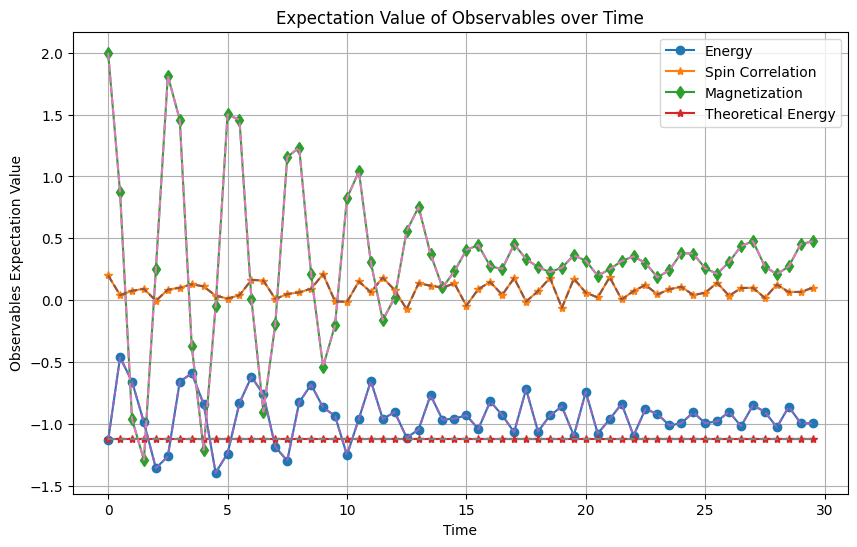

In [18]:

# Define the Hamiltonian terms
H_terms = [(-0.2,'IIIIZZ'), (-0.2,'IIIZZI'), (-0.2 ,'IIZZII'), (-0.2,'IZZIII'), (-0.2,'ZZIIII'),
               (-0.459,'IIIIIZ'), (-0.459,'IIIIZI'), ( -0.459,'IIIZII'), (-0.459,'IIZIII'), (-0.459,'IZIIII'), ( -0.459,'ZIIIII'), 
               (-1.109,'IIIIIX'), (-1.109,'IIIIXI'), (-1.109,'IIIXII'), (-1.109,'IIXIII'), (-1.109,'IXIIII'), (-1.109,'XIIIII')]


H_terms_spin_correlation = [(0.2,'IIIIZZ'), (0.2,'IIIZZI'), (0.2,'IIZZII'), (0.2,'IZZIII'), (0.2,'ZZIIII')]

H_terms_magnetization = [(1,'IIIIIZ'), (1,'IIIIZI'), (1,'IIIZII'), (1,'IIZIII'), (1,'IZIIII'), (1, 'ZIIIII')]

H_terms_multiple = [H_terms, H_terms_spin_correlation, H_terms_magnetization] #pass this into a function, and check if each term is in.

H_terms_names = ["Energy", "Spin Correlation", "Magnetization"]

n_spins = 6

# Initial state (|psi>)
initial_state = [
            0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
            0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
            0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
            0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
            0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
            0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
            0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
            0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j
        ]

H = get_hamiltonian(L=6, J=0.2, h=1.2, alpha=pi / 8)

#########################################

# compute expectation value for multiple observables after Trotterized evolution to given step count
def test_2_quantum(initial_state, H_terms_multiple, step, step_size, num_shots=10000):

    qc = QuantumCircuit(6) 

    # create a quantum circuit from the first of the Hamiltonian in the first element of the array
    qc = create_quantum_test_circuit(initial_state, H_terms_multiple[0], step, step_size)

    # Obtain all the estimated observables by executing the circuit on the backend and compute each observable
    observables = obs.estimate_expectation2(backend, qc, H_terms_multiple, num_shots=num_shots)
  
    return observables

#############################################

# total evolution time
total_evolution_time = 30

# for Trotterized evolution, specify size of each step
step_size = 0.5

# compute number of trotter steps 
num_steps = int(total_evolution_time / step_size)

#########################################

time_values = []
observables_list = []

# Create array of theoretical energies (for comparison)
# We compute this in an array function so that we can do the matrix conversion just once for all the steps
theoretical_energies = compute_theoretical_energy2(H, total_evolution_time, num_steps)

# pre-populate the observables value arrays with empty arrays
# this is done here so we can computer multiple observables from a single execution set
for i in range(len(H_terms_multiple)):
    observables_list.append([])

# loop over successively longer time steps to create arrays of obeservable values
for step in range(num_steps):
    print(".", end="")
    
    time_values.append(step * step_size)

    total_evolution_time = step * step_size
    
    observables = test_2_quantum(initial_state, H_terms_multiple, step, step_size)

    # put each of the computed observables into the values array
    for j in range(len(observables)):
        observables_list[j].append(observables[j])
    
print("")

########### Plot

# Plot the results
plt.figure(figsize=(10, 6))

marker=['o', '*', 'd', '1', '2']

#####
for i in range(len(H_terms_multiple)):
    plt.plot(time_values, observables_list[i], label= H_terms_names[i], marker=marker[i])

plt.plot(time_values, theoretical_energies, label='Theoretical Energy', marker='*')

#####
for j in range(len(H_terms_multiple)):
    plt.plot(time_values, observables_list[j], linestyle='--')
    
plt.plot(time_values, theoretical_energies, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Observables Expectation Value')
plt.title('Expectation Value of Observables over Time')
plt.legend()
plt.grid(True)
plt.show()


### ------------------------------------------------------------------